In [2]:
import json
with open('lmg_pretrained_pipeline.json', 'r') as f:
    data = json.load(f)


Pretrained layers: [3 6]
at 3 - 0 - 29 - 0: {'micro_auroc': 0.9021936058998108, 'mcc': 0.44778916616557185}
at 3 - 0 - 29 - 1: {'micro_auroc': 0.9164457321166992, 'mcc': 0.44662778490163035}
at 3 - 0 - 29 - 2: {'micro_auroc': 0.9165046215057373, 'mcc': 0.4795691193145529}
at 3 - 0 - 30 - 0: {'micro_auroc': 0.8684203028678894, 'mcc': 0.40162895875422744}
at 3 - 0 - 30 - 1: {'micro_auroc': 0.8767157196998596, 'mcc': 0.42408802131556617}
at 3 - 0 - 30 - 2: {'micro_auroc': 0.8766130208969116, 'mcc': 0.32868802578302825}
at 3 - 1 - 29 - 0: {'micro_auroc': 0.9136130213737488, 'mcc': 0.5144872953349569}
at 3 - 1 - 29 - 1: {'micro_auroc': 0.9197234511375427, 'mcc': 0.5149833535865337}
at 3 - 1 - 29 - 2: {'micro_auroc': 0.9194419384002686, 'mcc': 0.5047010181105942}
at 3 - 1 - 30 - 0: {'micro_auroc': 0.858299195766449, 'mcc': 0.4358361041145601}
at 3 - 1 - 30 - 1: {'micro_auroc': 0.8623562455177307, 'mcc': 0.45256606167766883}
at 3 - 1 - 30 - 2: {'micro_auroc': 0.8611626029014587, 'mcc': 0.4441

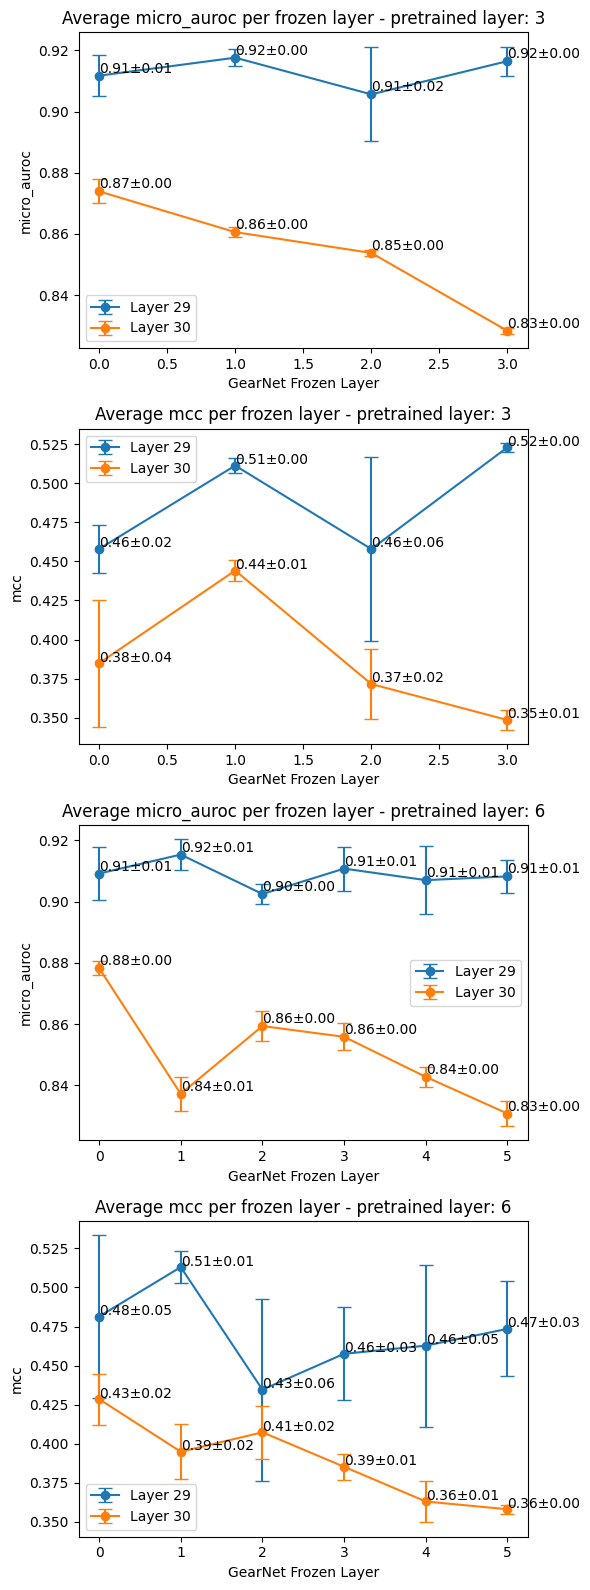

In [3]:
import matplotlib.pyplot as plt
from statistics import mean
import numpy as np

pretrained_layers = np.unique([d['pretrained_layers'] for d in data])

# Plotting
fig, axs = plt.subplots(len(pretrained_layers) * 2, figsize=(6, 8 * len(pretrained_layers)))


print(f'Pretrained layers: {pretrained_layers}')

for i, pretrained_layer in enumerate(pretrained_layers):
    data_pretrained_layer = [d for d in data if d['pretrained_layers'] == pretrained_layer]
    avg_metrics = {29: {'micro_auroc': [], 'mcc': []},
                   30: {'micro_auroc': [], 'mcc': []}}
    std_metrics = {29: {'micro_auroc': [], 'mcc': []},
                   30: {'micro_auroc': [], 'mcc': []}}
    
    gearnet_freeze_layers = [i for i in np.unique([d['gearnet_freeze_layer'] for d in data_pretrained_layer]) if i <= pretrained_layer]
    for gearnet_freeze_layer in gearnet_freeze_layers:
        data_gearnet_freeze = [d for d in data_pretrained_layer if d['gearnet_freeze_layer'] == gearnet_freeze_layer]
        for bert_freeze_layer in np.unique([d['bert_freeze_layer'] for d in data_gearnet_freeze]):
            metrics = {'micro_auroc': [], 'mcc': []}
            layer_data = [d for d in data_gearnet_freeze if d['bert_freeze_layer'] == bert_freeze_layer]
            for trial in np.unique([d['trial'] for d in layer_data]):
                trial_data = [d for d in layer_data if d['trial'] == trial]
                last_epoch_metric = trial_data[-1]['data']
                print(f'at {pretrained_layer} - {gearnet_freeze_layer} - {bert_freeze_layer} - {trial}: {last_epoch_metric}')
                metrics['micro_auroc'].append(last_epoch_metric['micro_auroc'])
                metrics['mcc'].append(last_epoch_metric['mcc'])

            avg_metrics[bert_freeze_layer]['micro_auroc'].append(
                np.mean(metrics['micro_auroc']))
            avg_metrics[bert_freeze_layer]['mcc'].append(np.mean(metrics['mcc']))
            std_metrics[bert_freeze_layer]['micro_auroc'].append(
                np.std(metrics['micro_auroc']))
            std_metrics[bert_freeze_layer]['mcc'].append(np.std(metrics['mcc']))

    # micro_auroc plot
    axs1 = axs[i * 2]
    for bert_freeze_layer in range(29, 31):
        axs1.errorbar(gearnet_freeze_layers, avg_metrics[bert_freeze_layer]['micro_auroc'],
                    yerr=std_metrics[bert_freeze_layer]['micro_auroc'], fmt='-o', capsize=5, label=f"Layer {bert_freeze_layer}")
        print(f'Layer {bert_freeze_layer} micro_auroc: {avg_metrics[bert_freeze_layer]["micro_auroc"]}')
        for layer, avg, std in zip(gearnet_freeze_layers, avg_metrics[bert_freeze_layer]['micro_auroc'], std_metrics[bert_freeze_layer]['micro_auroc']):
            axs1.text(layer, avg + 0.001, f'{avg:.2f}±{std:.2f}')
    axs1.set_title('Average micro_auroc per frozen layer - pretrained layer: ' + str(pretrained_layer))
    axs1.set_xlabel('GearNet Frozen Layer')
    axs1.set_ylabel('micro_auroc')
    axs1.legend()

    # mcc plot
    axs2 = axs[i * 2 + 1]
    for bert_freeze_layer in range(29, 31):
        axs2.errorbar(gearnet_freeze_layers, avg_metrics[bert_freeze_layer]['mcc'],
                    yerr=std_metrics[bert_freeze_layer]['mcc'], fmt='-o', capsize=5, label=f"Layer {bert_freeze_layer}")
        
        for layer, avg, std in zip(gearnet_freeze_layers, avg_metrics[bert_freeze_layer]['mcc'], std_metrics[bert_freeze_layer]['mcc']):
            axs2.text(layer, avg + 0.001, f'{avg:.2f}±{std:.2f}')
    axs2.set_title('Average mcc per frozen layer - pretrained layer: ' + str(pretrained_layer))
    axs2.set_xlabel('GearNet Frozen Layer')
    axs2.set_ylabel('mcc')
    axs2.legend()

plt.tight_layout()
plt.show()
